# Project: Why 20% of People don't Show-up on their Medical Appointments?
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling and Cleaning</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#Q6">Model & Prediction</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

It is not uncommon that people don't show up for medical appointments and miss their chance to receive proper treatments. Different reasons may be present such as forgetting appointments or something urgent had happened. Therefore, it would be helpful to understand the factors affecting people showing up on appointments and predict if a patient will miss their  appointment or not next time. The predictions can further help medical staffs to know which patients may need extra reminders.
<br><br>
The [dataset](https://www.kaggle.com/joniarroba/noshowappointments) that I will be analyzing contains objectively recorded data from 110527 patients, including when they scheduled appointments, date of appointment, which county they live in, or health conditions....etc. It may be argued that surveys can be more direct in analyzing the actual reason, but collecting a descent amount of surveys from patient to explore is difficult due to privacy reasons and the length of collection time. Therefore, to analyze a large data set and dissect underlying reasons for missing appointments, objectively recorded data can be a good place to start. 
<br><br>
The **goal** of this analysis is to find factors affecting people showing-up on appointments. 6 research questions (listed below) will be asked to help explore related features and the last part will contain a model built for finding the important factors and predicting if a patient will show up or not.

<ol>
    <li><a href="#Q1">Does most people show up for appointments?</a></li>
    <li><a href="#Q2">Do different gender or different age groups affect the show-up rate?</a></li>
    <li><a href="#Q3">Does health condition affect show-up rate?</a></li>
    <li><a href="#Q7">Do people show-up more if they have scholarship (financial aid)? What health conditions do they have generally?</a></li>
    <li><a href="#Q4">Does scheduling too early affect people showing up on appointment day?  </a></li>
    <li><a href="#Q5">Does sending message notifying patients improve show-up rate?</a></li>
</ol>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling and Cleaning

In [2]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Original data contains 110527 patient data and 14 features.

In [3]:
df.shape

(110527, 14)

In [4]:
df.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [5]:
# df.dtypes
# df.nunique()
# df.describe()

There are no duplicated rows or rows containing null values. To make the exploring process better, IDs of patients are dropped, our target variable No-show is separated into 2 columns 'Show' and 'No_show', which are encoded in 1s and 0s, difference of days between scheduled day and appointment day is calculated and added as a feature, and age is segmented into 4 groups using 1st, 2nd, and 3rd quartiles for better visualization. At last, the rows are dropped if age is under 0 or difference of days is under 0, since appointments should be either scheduled on the same day or before the appointment.

In [6]:
# drop duplicates
df.duplicated().sum() ##0
df.drop_duplicates(inplace = True)

# drop Id columns
df = df.drop(['PatientId', 'AppointmentID'], axis = 1)

# encode no-show column into 0s and 1s
dummy_noshow = pd.get_dummies(df['No-show']) 
dummy_noshow.columns = np.array(['Show', 'No_show'])
df = pd.concat([df, dummy_noshow], axis = 1)

# change schdule day and appointment day from string to datetime objects
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

# create new column with difference of days 
df['diff_days'] = df['AppointmentDay'] - df['ScheduledDay']
# appointment day is always at 0:00 but scheduled day is always greater or equal to 0:00, so the difference within -1~0 days is change to 0 days
df['diff_days'] = df['diff_days'].apply(lambda x: pd.Timedelta('0 days') if x >= pd.Timedelta('-1 days') and x < pd.Timedelta('0 days') else x) 
df['diff_days'] = df['diff_days'].dt.days

# get rid of rows with weird values
df = df.drop(df.query('Age < 0').index, axis = 0) # age less than 0
df = df.drop(df.query('diff_days < 0').index, axis = 0) # appointment day before scheduled day

# segment age column for exploration
def age_seperate(e):
    if e >= 0 and e <= 18:
        return '0-18'
    elif e > 18 and e <= 37:
        return '18-37'
    elif e > 37 and e <= 55:
        return '37-55'
    else:
        return '55+'
    
df['Age_group'] = df['Age'].apply(age_seperate)

In [7]:
df.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Show,No_show,diff_days,Age_group
0,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,1,0,0,55+
1,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,1,0,0,55+
2,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,1,0,0,55+
3,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,1,0,0,0-18
4,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,1,0,0,55+


After wrangling and cleaning, dataset contains 110521 patient data and 16 columns. 

In [8]:
# After cleaning
df.shape

(110521, 16)

<a id='eda'></a>
## Exploratory Data Analysis

<a id='Q1'></a>
### Q1: Does most people show up for appointments?

**Ans:** On average, 79.8% of people shows up for appointments and 20.2% doesn't show-up.

<br><a href="#intro">Back to List of Questions</a>

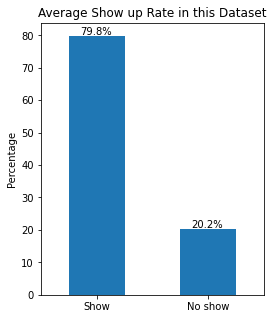

In [9]:
show_rates = df[['Show', 'No_show']].mean()*100
fig, ax = plt.subplots(figsize = (4,5))
ax = show_rates.plot(kind = 'bar')
ax.set_xticklabels(['Show', 'No show'],rotation = 0)
ax.set_title('Average Show up Rate in this Dataset')
ax.set_ylabel('Percentage');

for rect in ax.patches:
    ax.text (rect.get_x() + 0.1 ,rect.get_height()+0.5,"%.1f%%"% (rect.get_height()))

<a id='Q2'></a>
### Q2: Do different gender or age groups affect the show-up rate?
**Ans**: Gender does not affect the show-up rate. The statisitcs are similar to the overall show-up rate with 80% show-ups and 20% no-shows. However, there are differences in the age groups. People who age 55 or above shows up the most with 84.4% show-up rate and 15.6% the lowest no-show rate. On the other hand, people who age between 18-37 has the most no-show rate 23.5%, which is 8.5% higher than the 55+ age group.

<br><a href="#intro">Back to List of Questions</a>

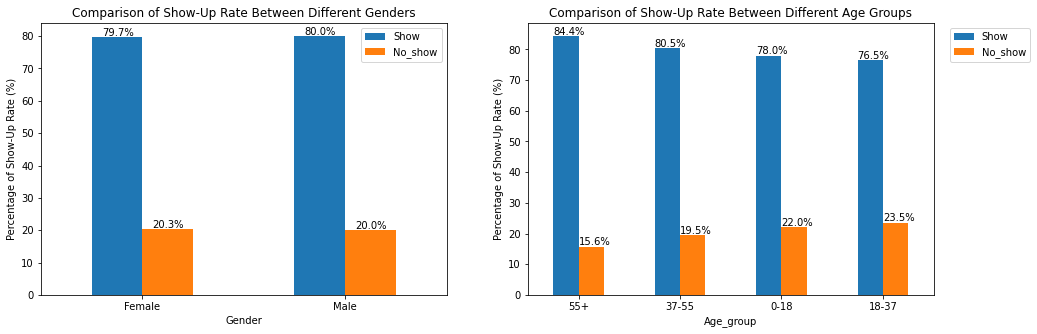

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
showup_rate_gender = df.groupby('Gender').mean()[['Show', 'No_show']]*100
showup_rate_gender.plot(kind = 'bar', ax = ax[0])

ax[0].legend(loc= 'upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
ax[0].set_xticklabels(['Female', 'Male'], rotation=0)
ax[0].set_ylabel('Percentage of Show-Up Rate (%)')
ax[0].set_title('Comparison of Show-Up Rate Between Different Genders');
for rect in ax[0].patches:
    ax[0].text (rect.get_x()+ 0.05,rect.get_height()+0.5,"%.1f%%"% (rect.get_height()))
    
showup_rate_age = df.groupby('Age_group').mean()[['Show', 'No_show']]*100
showup_rate_age = showup_rate_age.sort_values('Show', ascending = False)
showup_rate_age.plot(kind = 'bar', ax = ax[1])
ax[1].legend(loc= 'upper right', bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))
ax[1].set_xticklabels(np.array(showup_rate_age.index), rotation=0)
ax[1].set_ylabel('Percentage of Show-Up Rate (%)')
ax[1].set_title('Comparison of Show-Up Rate Between Different Age Groups');

for rect in ax[1].patches:
    ax[1].text (rect.get_x(),rect.get_height()+0.5,"%.1f%%"% (rect.get_height()))

<a id='Q3'></a>
### Q3: Does health condition affect no show rate?

**Ans:** Yes, there are observable differences in show-up rates among people who have these conditions, especially for 'Hipertension' and 'Diabetes' patients. On average, people tend to show-up more if they have a health condition present. 

<br><a href="#intro">Back to List of Questions</a>

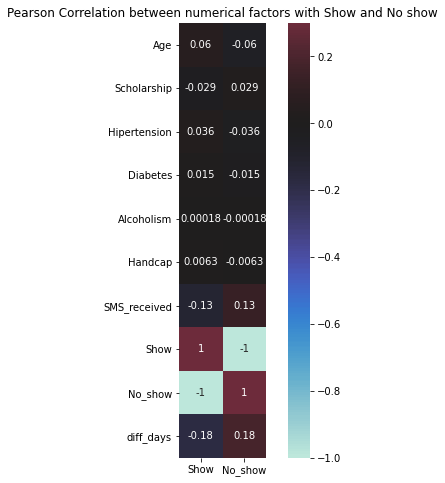

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(df.corr()[['Show', 'No_show']], annot =True, vmax=.3, center=0, square=True, )
plt.title('Pearson Correlation between numerical factors with Show and No show');

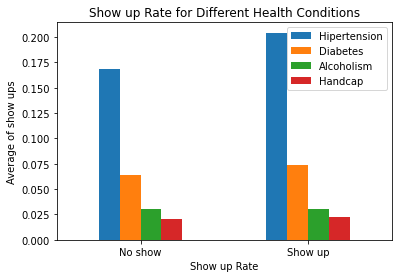

In [12]:
ax = df.groupby('Show').mean()[['Hipertension', 'Diabetes', 'Alcoholism', 'Handcap']].plot(kind = 'bar')
ax.set_xticklabels(['No show', 'Show up'], rotation =0)
ax.set_xlabel('Show up Rate')
ax.set_title('Show up Rate for Different Health Conditions')
ax.legend(loc = 'upper right', bbox_to_anchor = (0.5, 0.5, 0.5, 0.5))
ax.set_ylabel('Average of show ups');

<a id='Q7'></a>
### Q4: Do people show-up more if they have scholarship (financial aid)? What health conditions do they have generally?
**Ans:** Yes, according to the first graph below, people who recieves Scholarship (financial aid) tend to show-up less. Checking their health conditions, it was found that the trend that people who have health condition shows up more on appointments is present in three condition except 'Alcoholism'. It was found that people with scholarship and alcoholism show up less to medical appointments. 

<br><a href="#intro">Back to List of Questions</a>

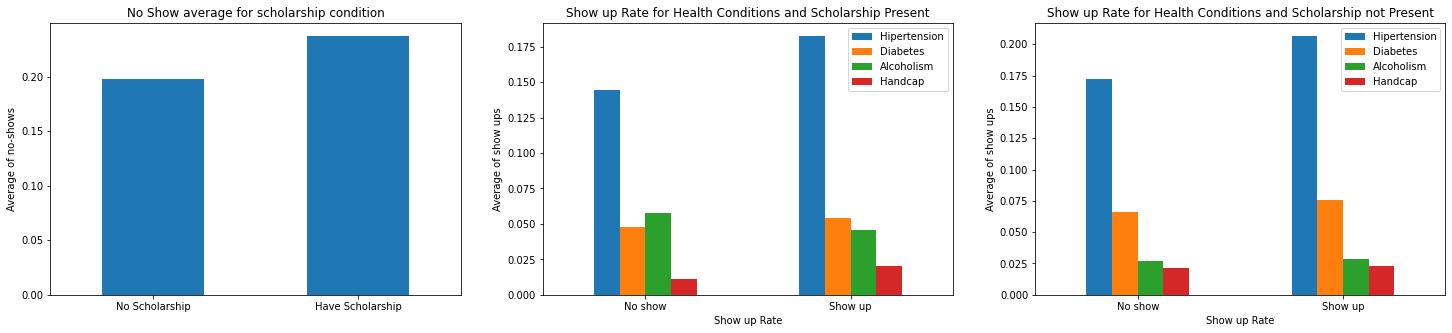

In [13]:
fig, ax = plt.subplots(1, 3, figsize = (25, 5))
df.groupby('Scholarship').mean()[['No_show']].plot(kind = 'bar', ax= ax[0])
ax[0].set_title('No Show average for scholarship condition')
ax[0].set_xticklabels(['No Scholarship', 'Have Scholarship'], rotation =0)
ax[0].set_xlabel('')
ax[0].set_ylabel('Average of no-shows')
ax[0].get_legend().remove()

df.query('Scholarship == 1').groupby('Show').mean()[['Hipertension', 'Diabetes', 'Alcoholism', 'Handcap']].plot(kind = 'bar', ax = ax[1])
ax[1].set_xticklabels(['No show', 'Show up'], rotation =0)
ax[1].set_xlabel('Show up Rate')
ax[1].set_title('Show up Rate for Health Conditions and Scholarship Present')
ax[1].legend(loc = 'upper right', bbox_to_anchor = (0.5, 0.5, 0.5, 0.5))
ax[1].set_ylabel('Average of show ups');

df.query('Scholarship == 0').groupby('Show').mean()[['Hipertension', 'Diabetes', 'Alcoholism', 'Handcap']].plot(kind = 'bar', ax = ax[2])
ax[2].set_xticklabels(['No show', 'Show up'], rotation =0)
ax[2].set_xlabel('Show up Rate')
ax[2].set_title('Show up Rate for Health Conditions and Scholarship not Present')
ax[2].legend(loc = 'upper right', bbox_to_anchor = (0.5, 0.5, 0.5, 0.5))
ax[2].set_ylabel('Average of show ups');


<a id='Q4'></a>
### Q5: Does scheduling too early affect people showing up on appointment day? 

**Ans:** Yes, according to the correlation map, the length of days between scheduled day and appointment day showed the largest negative correlation whether people will show up, meaning that the longer the distance between scheduled day and appointment day the less likely people will show-up. The average days of no-show appointments have a difference of days around 15 and show-up appointments have a difference around 8 days. Also, the box plot below showed that on average people show-up more when scheduled day is closer to appointment days and less data points are present after the 125 day mark for show-up box-plot. 

<br><a href="#intro">Back to List of Questions</a>

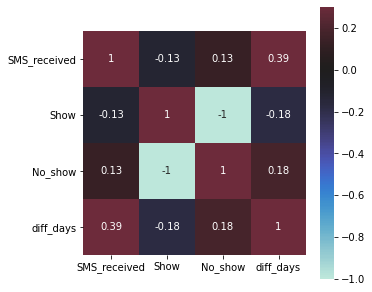

In [14]:
plt.subplots(figsize=(5, 5))
sns.heatmap(df.corr().iloc[6:, 6:], annot =True, vmax=.3, center=0, square=True);

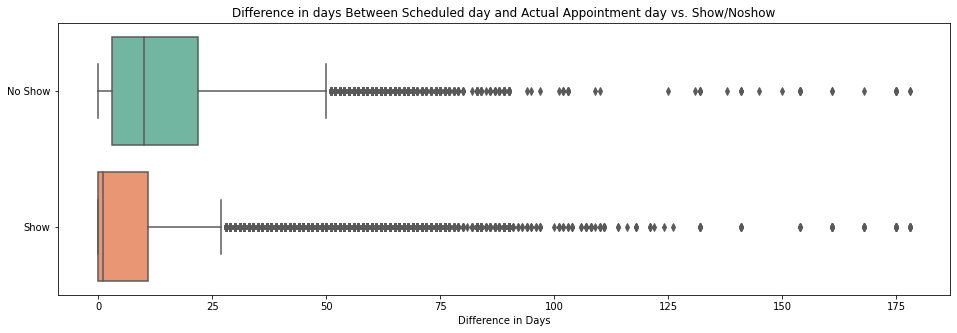

In [15]:
fig, ax = plt.subplots(figsize = (16, 5))
ax = sns.boxplot(x="diff_days", y="Show", data=df, orient="h", palette = 'Set2')
ax.set_yticklabels(['No Show', 'Show'], rotation = 0)
plt.title('Difference in days Between Scheduled day and Actual Appointment day vs. Show/Noshow');
plt.xlabel('Difference in Days')
plt.ylabel('');

In [16]:
avg_q3 = df.groupby('Show').mean()[['diff_days']].rename(index = {1: 'Show', 0: 'No_show'})
avg_q3

,diff_days
Show,
No_show,14.915793
Show,8.171619


<a id='Q5'></a>
### Q6: Does sending message notifying patients improve show up rate?
**Ans:** The answer is not conclusive in this case. The upper plot showed that on average, people who received messages are less likely to show up, but this cannot be a direct indicator of show-ups or no shows, since on the bottom plot a possbility is shown that people that has longer days between scheduled and appointment day may receive more messages. Therefore, qualitative data such as asking patients if receiving message is helpful in reminding would be helpful to determine the underlying relationship.

<br><a href="#intro">Back to List of Questions</a>

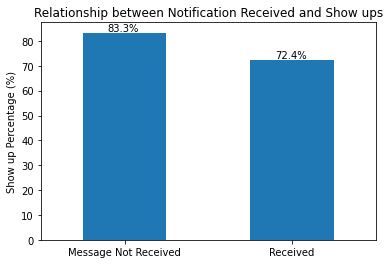

In [17]:
ax = (df.groupby('SMS_received').mean()[['Show']]*100).plot(kind = 'bar')
ax.set_xticklabels(['Message Not Received', 'Received'], rotation = 0)
ax.set_xlabel('')
ax.set_ylabel('Show up Percentage (%)')
ax.get_legend().remove()
ax.set_title('Relationship between Notification Received and Show ups');
for rect in ax.patches:
    ax.text (rect.get_x()+ 0.15,rect.get_height()+0.5,"%.1f%%"% (rect.get_height()))

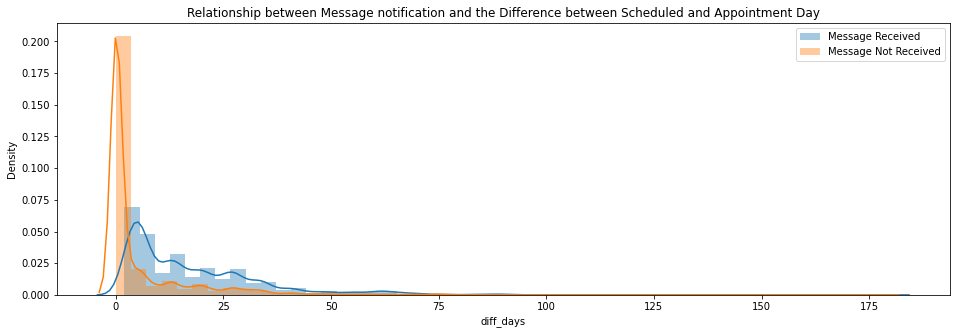

In [18]:
fig, ax = plt.subplots(figsize = (16, 5))
sns.distplot(df.query('SMS_received == 1')['diff_days'], label = 'Message Received')
sns.distplot(df.query('SMS_received == 0')['diff_days'], label = 'Message Not Received')
plt.legend()
plt.title('Relationship between Message notification and the Difference between Scheduled and Appointment Day');

<a id='Q6'></a>
### Model and Prediction
#### Q: What factors are important to predict if a patient will show up for their scheduled appointment? 
Since the target label is imbalanced with ~80% show up appointments and only ~20% no show appointments, so data was sampled from show-up appointments using number of no-show appoints to balance dataset with same number of data in both types, yielding final input with 44628 patients and 9 numerical features. 

Logistic Regression was used to predict the target variable. One feature is added at a time in the order of highest pearson correlation to lowest with 'Show' variable in order to observe the marginal improvement of the model. At last, the best number of features will be selected with the highest test accuracy. 

<br>**Ans**: After performing Logistic Regression to predict if a patient shows up or not with 9 features in the data set, 5 features **'SMS_received', 'Scholarship', 'Hipertension', 'diff_days', 'Age'** , ranking from most impactful to least impactful, are selected as the best number of features to perform prediction. The best model yielded a 62.47 % training accuracy and 62.17% test accuracy. The features are proven to be better than random guess and is helpful in predicting if patient will show-up or not since its test accuracy is greater than 50% (random guess). 

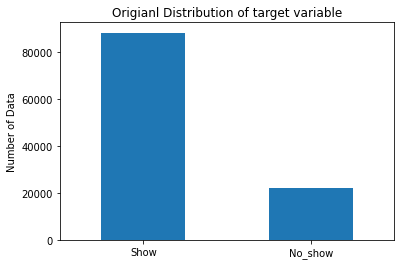

In [19]:
ax = (df['Show'].value_counts()).plot(kind = 'bar')
ax.set_title('Origianl Distribution of target variable')
ax.set_xticklabels(['Show', 'No_show'], rotation = 0)
ax.set_ylabel('Number of Data');

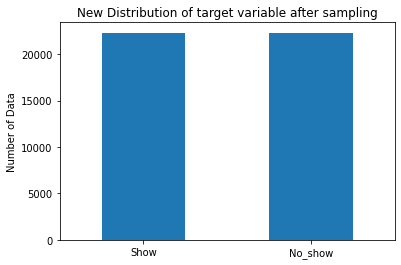

In [20]:
# to balance out show and no-show appointments
copy = df.copy()
copy['Gender'] = copy['Gender'].apply(lambda x: 1 if x == 'M' else 0)
new_df = pd.concat([copy.query('Show == 1').sample(n = 22314, random_state = 1),copy.query('Show == 0').sample(n = 22314, random_state = 1)])[['Gender', 'Age', 
       'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'Show', 'diff_days']]
new_df = new_df.sample(frac = 1, random_state = 200)

# plot
ax = new_df['Show'].value_counts().plot(kind = 'bar')
ax.set_title('New Distribution of target variable after sampling')
ax.set_xticklabels(['Show', 'No_show'], rotation = 0)
ax.set_ylabel('Number of Data')

# feature input order determined by high correlation
cols = new_df.corr()['Show'].sort_values(key = abs, ascending = False).index[1:]

Final sample size is 44628 with 9 features and 1 target variable.

In [21]:
new_df.shape

(44628, 10)

Since correlation and logistic regression are both associated with linear models, the input feature is ordered from greatest to lowest correlation with 'Show' variable. In this way, the increase in accuracy and mean square error can be easily visualized and understand. 

Best model:

Number of features: 5
Train accuracy: 62.47%
Test accuracy: 62.17%
Mean Square Error: 0.378
Features used: ['diff_days' 'SMS_received' 'Age' 'Hipertension' 'Scholarship']


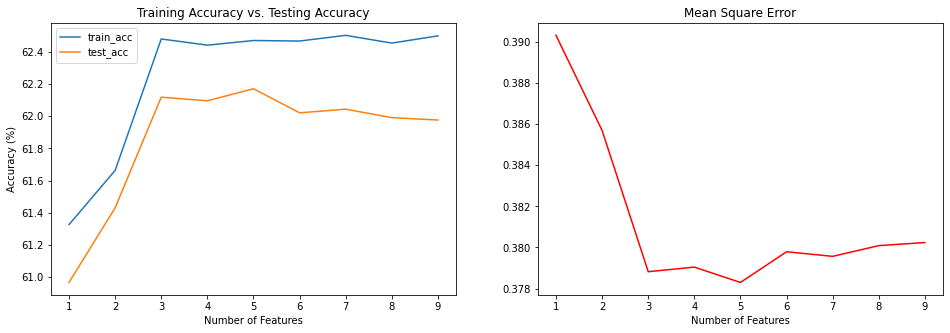

In [22]:
def training_plot(cols):
    test_acc= np.array([])
    train_acc= np.array([])
    mse= np.array([])
    
    for i in range(len(cols) + 1):
        if i == 0:
            continue
            
        # split dataset
        X = new_df[cols[:i]]
        y = new_df['Show']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=0)
        
        # fit model
        model = LogisticRegression(random_state=1)
        model.fit(X_train, y_train)
        
        # Accuracies + MSE
        y_pred = model.predict(X_test)       
        test_acc = np.append(test_acc, model.score(X_test, y_test)*100)
        train_acc = np.append(train_acc, model.score(X_train, y_train)*100)
        mse = np.append(mse, mean_squared_error(y_test, y_pred))
    
    # plots
    fig, ax = plt.subplots(1, 2, figsize = (16, 5))
    acc = pd.DataFrame([train_acc, test_acc],index = ['train_acc', 'test_acc']).T
    acc.plot(ax = ax[0])
    ax[0].set_xticklabels(np.arange(len(cols) + 1))
    ax[0].set_title('Training Accuracy vs. Testing Accuracy')
    ax[0].set_ylabel('Accuracy (%)')
    ax[0].set_xlabel('Number of Features')
    
    ax[1].plot(mse, color = 'red')
    ax[1].set_xticklabels(np.arange(len(cols) + 1))
    ax[1].set_title('Mean Square Error')
    ax[1].set_xlabel('Number of Features')
    
    print('Best model:', end = '\n\n')
    best_i = np.argmax(test_acc)
    print(f'Number of features: {best_i + 1}')
    print(f'Train accuracy: {np.round(train_acc[best_i], 2)}%')
    print(f'Test accuracy: {np.round(test_acc[best_i], 2)}%')

    # MSE
    print(f'Mean Square Error: {round(mse[best_i], 3)}')
    print(f'Features used: {np.array(cols[:best_i + 1])}')

    return best_i

best_i = training_plot(cols)

In [23]:
# split dataset
X = new_df[cols[:best_i + 1]]
y = new_df['Show']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=0)

# fit model
best_model = LogisticRegression(random_state=1)
best_model.fit(X_train, y_train)
pd.DataFrame([cols[:best_i + 1], best_model.coef_[0]], index = ['Features', 'Coefficient']).T.sort_values(key =abs, by = 'Coefficient', ascending = False)

,Features,Coefficient
1,SMS_received,-0.392971
4,Scholarship,-0.170867
3,Hipertension,0.029849
0,diff_days,-0.026341
2,Age,0.00704


<a id='conclusions'></a>
## Conclusions


According to the model, 5 factors 'SMS_received', 'Scholarship', 'Hipertension', 'diff_days', 'Age' are selected as the most impactful variables to make prediction. To give an example of a person that will most likely miss an appointment according to this model is a young person who receives 1+ appointment messages, receives scholarship(financial aid), doesn't have hypertension, and scheduled appointment very far apart from date of scheduling. 

In conclusion, from our data set we discovered that these five factors, time, notification received or not, having financial aid or not, age, and hypertension, are important in determining if a person will show-up for his/her next appointment. Due to the small number of features, the model is not realistic enough to fit in the modern world, since there is a variety of conditions in the real world. For future analysis, more features should be included such as the frequency of patient coming to hospital, their occupation, or what type of doctor they met to obtain better predictions and generalize better to unseen data. In addition to more features, different methods can also be tried in future, for example SVM, random forest, or deep learning methods as well as new ways of dealing with imbalanced data and selecting appropriate features for final model. 
